### Source
source: https://github.com/wiseodd/generative-models/tree/master/GAN/vanilla_gan

### Summary
Try Fitting Gaussian Mixed Model

### Log


### Brian-storm


In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math
from sklearn import mixture
%matplotlib inline

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

### Parameters

In [7]:
epoch_n = 12000
dt_steps = 5
dg_steps = 1
mb_size = 256
X_dim = 2
z_dim = 2
h_dim = 16

### Data Steps


In [10]:
def generate_GMM(n):
    C = np.array([[0., -0.7], [3.5, .7]])
    g1 = np.random.randn(n, 2) + np.array([20, 20])
    g2 = np.random.randn(n, 2) + np.array([0, 10])
    g3 = np.dot(np.random.randn(n, 2), C)
    combine_g = np.vstack([g1, g2, g3])
    return combine_g

def sample_GMM(gen_GMM, n_samples):
    n_row = gen_GMM.shape[0]
    idx = np.random.randint(n_row, size = n_samples)
    return gen_GMM[idx, :]

# generate prior noise
def sample_z(m, n):
    return np.random.uniform(-1., 1., size = [m, n])

In [9]:
GMM_pop = generate_GMM(2000)

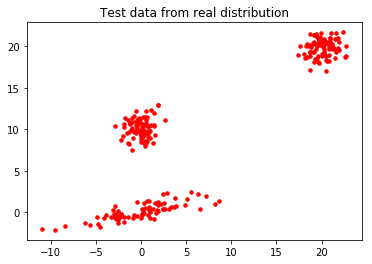

In [28]:
test_data = sample_GMM(GMM_pop, mb_size)
plt.scatter(test_data[:, 0], test_data[:, 1], c = 'r', s = 12)
plt.title('Test data from real distribution');

### Weight

In [14]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W3 = tf.Variable(xavier_init([h_dim, 1]))
D_b3 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]


Z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W3 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b3 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

### Model Architecture

In [15]:
def generator(z):
    G_h1 = tf.nn.leaky_relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
    output = tf.matmul(G_h2, G_W3) + G_b3    
    #G_prob = tf.nn.sigmoid(G_log_prob) # curse of mode collapse
    return output

def discriminator(x):
    D_h1 = tf.nn.leaky_relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    #D_prob = D_logit
    return D_prob, D_logit

In [16]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

In [17]:
# alternative loss function
#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

# original paper
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

D_solver = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(G_loss, var_list=theta_G)

### Training

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [19]:
for it in range(epoch_n):
    # discriminator steps
    for _ in range(dt_steps):
        X_batch = sample_GMM(GMM_pop, mb_size)
        Z_batch = sample_z(mb_size, 2)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    # generator step
    for _ in range(dg_steps):
        Z_batch = sample_z(mb_size, 2)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_batch})

    if it % 1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(it, D_loss_curr, G_loss_curr))

print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(it, D_loss_curr, G_loss_curr))

Iterations: 0	 Discriminator loss: 1.0555	 Generator loss: 0.5225
Iterations: 1000	 Discriminator loss: 0.6824	 Generator loss: 1.4976
Iterations: 2000	 Discriminator loss: 0.7818	 Generator loss: 1.3944
Iterations: 3000	 Discriminator loss: 0.6860	 Generator loss: 1.4727
Iterations: 4000	 Discriminator loss: 0.6959	 Generator loss: 1.4553
Iterations: 5000	 Discriminator loss: 0.7858	 Generator loss: 1.4405
Iterations: 6000	 Discriminator loss: 0.7247	 Generator loss: 1.4199
Iterations: 7000	 Discriminator loss: 0.7013	 Generator loss: 1.4290
Iterations: 8000	 Discriminator loss: 0.7178	 Generator loss: 1.4200
Iterations: 9000	 Discriminator loss: 0.7968	 Generator loss: 1.4377
Iterations: 10000	 Discriminator loss: 0.7286	 Generator loss: 1.3934
Iterations: 11000	 Discriminator loss: 0.7984	 Generator loss: 1.4522
Iterations: 11999	 Discriminator loss: 0.7933	 Generator loss: 1.3630


### Visualization

In [20]:
z_samples = sample_z(mb_size, 2)
g_samples = sess.run(G_sample, feed_dict={Z: z_samples})
r_samples = sample_GMM(GMM_pop, mb_size)

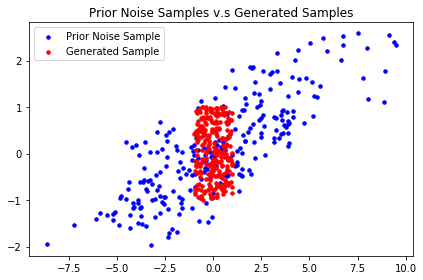

In [31]:
noise = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
transform = plt.scatter(x = z_samples[:, 0], y = z_samples[:, 1], c = 'r', s = 12)
plt.legend((noise, transform), ('Prior Noise Sample', 'Generated Sample'))
plt.title('Prior Noise Samples v.s Generated Samples');
plt.tight_layout();

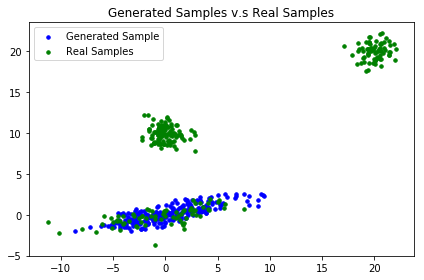

In [32]:
transform = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
real = plt.scatter(r_samples[:, 0], r_samples[:, 1], c = 'g', s = 12)
plt.legend((transform, real), ('Generated Sample', 'Real Samples'))
#plt.ylim((0, 100))
plt.title('Generated Samples v.s Real Samples')
plt.tight_layout();

- Mope Collapse occurs!!

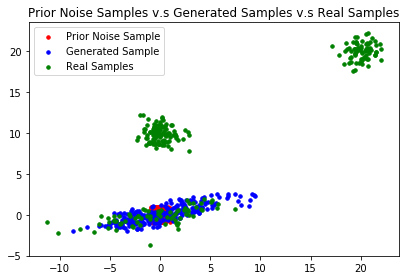

In [33]:
noise = plt.scatter(x = z_samples[:, 0], y = z_samples[:, 1], c = 'r', s = 12)
transform = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
real = plt.scatter(r_samples[:, 0], r_samples[:, 1], c = 'g', s = 12)
plt.legend((noise, transform, real), ('Prior Noise Sample', 'Generated Sample', 'Real Samples'))
#plt.ylim((0, 100))
plt.title('Prior Noise Samples v.s Generated Samples v.s Real Samples')
plt.tight_layout();